# Model Haar interferometer with squeezed states, with training on differential particle number

We test the boson sampling operator 
on coherent states and squeezed states, and 
propagating in a random medium

We train the random medium to minimize <(n0-n1)^2> with a differential layer

A linear interferometer is used for training

Squeezing parameters are not trained

nonlinearxwaves@gmail.com<br>
@version 9 feb 2021 <br>
@version 5 may 2023

In [1]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools as it

2023-05-05 06:00:19.058391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-05 06:00:19.058413: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
#np.set_printoptions(precision=4)

Check GPU

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
import warnings
warnings.filterwarnings('ignore')

## Dimension

In [9]:
N = 12

In [10]:
n=np.floor_divide(N,2)

In [11]:
nmodes = int(n)

In [12]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [13]:
vacuum = ps.VacuumLayer(N)

## Parameter for squeezing

In [14]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [15]:
HAAR=ps.HaarLayerConstant(N)

In [16]:
R=ps.RandomLayer(N) # trainable layer

## Build the model (the squeezed states are not trainable)
squeezed states are generated and mixed by a random medium and then go into an Haar Inteferometer

In [17]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
x1, a1 = R(x1,a1)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j, trainable=False)(x1,a1)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [18]:
model.input_shape[1]

12

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 random_layer (RandomLayer)     [(None, 12),         72          ['haar_layer_constant[0][0]',    
                                 (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                              

## Photon counting layer 

Dummy input

In [20]:
Nbatch=10
xtrain = np.random.rand(Nbatch, N)-0.5

Model with the photon counting layer

In [21]:
photon_counter=ps.PhotonCountingLayer(N) # define the layer
n_out = photon_counter(chir,chir, model);  # define the output tensor
Nphoton = tf.keras.Model(inputs = xin, outputs=n_out) # define the model with inputs and ouputs
tf.print(Nphoton(xtrain)); 

[[0.996120691 0.996120811 0.996120334 0.996120691 0.99612093 0.996120691]]


# Differential Gaussian Layer

In [22]:
Diff=ps.DifferentialGaussianLayer(N)
nboson, Dn, Dn2 = Diff(chir,chii, model)
HModel = tf.keras.Model(inputs = xin, outputs=[nboson,Dn2])

In [23]:
n_out,Dn_out=HModel(xtrain)
tf.print(Dn_out)

[[0 5.67235 2.47956133 6.09471226 5.7744236 5.12272644]
 [5.67235 0 5.59847 7.45187044 7.16948223 6.77871]
 [2.47956133 5.59847 0 5.85954 5.66431665 4.18332767]
 [6.09471226 7.45187044 5.85954 0 7.41097784 6.93178749]
 [5.7744236 7.16948223 5.66431665 7.41097784 0 6.68504906]
 [5.12272644 6.77871 4.18332767 6.93178749 6.68504906 0]]


Initial differential corrents

In [24]:
tf.gather_nd(Dn_out,[[0,1]])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([5.67235], dtype=float32)>

Photon numbers before training

In [25]:
tf.print(n_out)

[[0.996120691 0.996120811 0.996120334 0.996120691 0.99612093 0.996120691]]


In [26]:
tf.reduce_mean(n_out)

<tf.Tensor: shape=(), dtype=float32, numpy=0.9961207>

In [27]:
tf.gather_nd(n_out,[[0,1]])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9961208], dtype=float32)>

# Heisenberg Layer

In [28]:
Heis=ps.HeisenbergGaussianLayer(N)
nbosonH, nboson2, Dnboson2 = Heis(chir,chii, model)
HModel2 = tf.keras.Model(inputs = xin, outputs=[nbosonH, nboson2 , Dnboson2])

In [29]:
nHout,n2Hout,D2Hout=HModel2(xtrain)
tf.print(n2Hout)
tf.print(tf.gather_nd(n2Hout,[[0,0]]))

[[3.37686419 4.63138247 3.15043592 4.81104946 4.63694382 4.13650131]]
[3.37686419]


## Model with the target output to train

Model with the custom ouput to train

In [30]:
Dn_out01=tf.gather_nd(Dn2,[[0,1]]) #check this
#n2_out0=tf.gather_nd(nboson2,[[0,0]])
#n2_out1=tf.gather_nd(nboson2,[[0,1]])
#train_out=tf.exp(-Dn_out01+n2_out0+n2_out1)
train_out=tf.exp(Dn_out01,name='Dn01')
nboson0=tf.gather_nd(nboson,[[0,0]], name='n0')
nboson1=tf.gather_nd(nboson,[[0,1]], name='n1')
Train_model = tf.keras.Model(inputs = xin, outputs=[train_out, nboson0, nboson1]) # define the model with inputs and ouputs

Define the custom loss to train the model for maximum output

In [31]:
def custom_loss(yt,yp):
    # the loss only return the output of the network yp
    # that need to be minimized
    return yp
Train_model.compile(loss=custom_loss, optimizer='Adam')

In [32]:
#Train_model.add_loss(train_out)
#Train_model.add_loss(nboson0)
#Train_model.add_loss(nboson1)
#Train_model.compile(optimizer='Adam')

# Transform model

In [33]:
kin, Qrho =ps.getQTransformModel(model)

In [34]:
Qrho.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             240       
 rmLayer)                                                        
                                                                 
Total params: 240
Trainable params: 72
Non-trainable params: 168
_________________________________________________________________


# Test the Pr operator 

Probability of zero photon

In [35]:
ps.Pr([0]*nmodes, Qrho)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.12573017]], dtype=float32)>

Probability of two photons

In [36]:
nbar = [0]*nmodes
nbar[0]=2
print(nbar)
ps.Pr(nbar, Qrho)

[2, 0, 0, 0, 0, 0]


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00625148], dtype=float32)>

# Generate all the possible photon patterns assuming max one photon per mode

In [37]:
def patterns(nphotons, nmodes):
    # Return the patterns of nmodes with maximal nphotons
    
    # generate a list of zero
    l1=[0]*nmodes
    # set nphotons 1
    for j in range(nphotons):
        l1[j]=1
    # compute all the permutations (zeros and one are distinguishable)
    nlist=it.permutations(l1,nmodes) # return iterators
    # convert to list the iterators
    ln=list(nlist)
    # sort the list in reverse order to have the patterns with more ones first
    ln.sort(reverse=True)
    # remove duplicates (remove adjactent identical elements after sorting)
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [38]:
ln =patterns(2,nmodes)
print(ln)
print(len(ln))

[(1, 1, 0, 0, 0, 0), (1, 0, 1, 0, 0, 0), (1, 0, 0, 1, 0, 0), (1, 0, 0, 0, 1, 0), (1, 0, 0, 0, 0, 1), (0, 1, 1, 0, 0, 0), (0, 1, 0, 1, 0, 0), (0, 1, 0, 0, 1, 0), (0, 1, 0, 0, 0, 1), (0, 0, 1, 1, 0, 0), (0, 0, 1, 0, 1, 0), (0, 0, 1, 0, 0, 1), (0, 0, 0, 1, 1, 0), (0, 0, 0, 1, 0, 1), (0, 0, 0, 0, 1, 1)]
15


## Make a plot versus the probability

Build an array of photon number sampling

In [39]:
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.005543915
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
0.032552384
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
0.0017148163
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
0.0040212083
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
0.0064076097
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
0.0031371024
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
9.542331e-05
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
0.0018038396
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
7.35363e-05
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
0.0018527997
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
0.0021859684
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
0.017656483
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.00082835206
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.00049305917
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
0.0016389927
Done


Store data for plot

In [40]:
ln2u=ln
Pn2u=Pn

Plot

(0.0, 0.07)

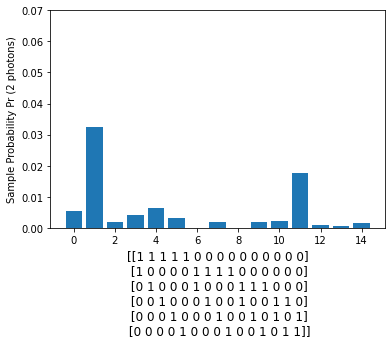

In [41]:
plt.bar(range(len(ln2u)),Pn2u)
plt.xlabel(np.transpose(np.array(ln2u)), fontsize=12);
plt.ylabel('Sample Probability Pr (2 photons)');
plt.ylim((0,0.07))

## Patterns with 4 photons

In [42]:
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')


15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
0.00028141364
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
0.0006634772
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
0.00030870028
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
1.6782287e-06
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
6.128117e-06
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
0.0002055289
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
0.00028678836
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
0.00065196224
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
0.0010647376
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
4.947862e-06
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
5.492044e-06
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
6.216934e-05
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
0.00025640638
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
2.8215582e-06
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
6.31843e-05
Done


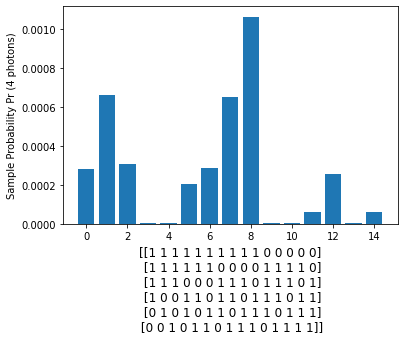

In [43]:
plt.bar(range(npatterns),Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr (4 photons)');

## Compute the probability of pairs 

In [44]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.12573017179965973 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.005543915089219809 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=0.032552383840084076 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=0.0017148163169622421 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=0.004021208267658949 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=0.006407609675079584 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=0.0031371023505926132 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=9.542331099510193e-05 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=0.0018038395792245865 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=7.353629916906357e-05 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.0018527996726334095 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.0021859684493392706 pattern (0, 0, 1, 0, 1

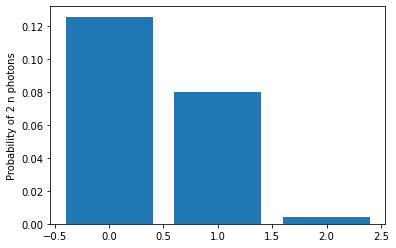

In [45]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');

# Train the model and recompute probabilities

In [46]:
%%time
history=Train_model.fit(xtrain,np.zeros_like(xtrain),epochs=5000,verbose=0)

CPU times: user 2min 1s, sys: 13.9 s, total: 2min 15s
Wall time: 1min 5s


Plot training history

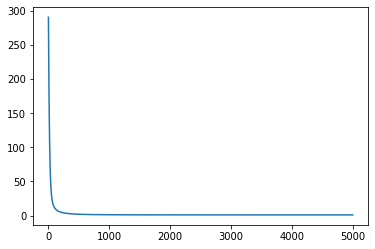

In [47]:
plt.plot(history.history['tf.math.exp_loss'])

Plot the training history in log scale (corresponding to Dn2_01, n0 and n1)

(0.0, 4.0)

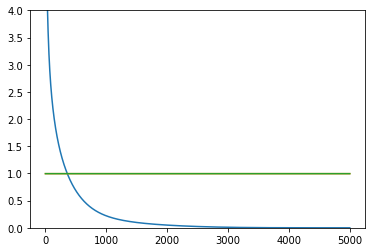

In [48]:
plt.plot(np.log(history.history['tf.math.exp_loss']))
plt.plot(history.history['tf.compat.v1.gather_nd_1_loss'])
plt.plot(history.history['tf.compat.v1.gather_nd_2_loss'])
plt.ylim((0,4.0))

Plot number of photons

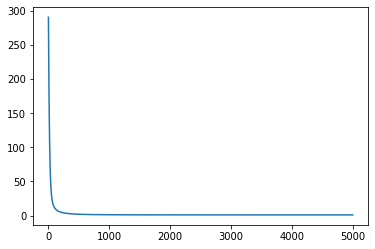

In [49]:
plt.plot(history.history['tf.math.exp_loss'])

## Photon number after training

In [50]:
tf.print(Nphoton(xtrain)); 

[[0.996120691 0.996120214 0.996120334 0.996120691 0.996120691 0.996120572]]


In [51]:
tf.reduce_mean(Nphoton(xtrain))

<tf.Tensor: shape=(), dtype=float32, numpy=0.9961205>

## Photon correlations after training

In [52]:
n_out,Dn_out=HModel(xtrain)
tf.print(Dn_out)
tf.print(tf.gather_nd(Dn_out,[0,1]))

[[0 7.62939453e-06 4.36722612 5.70377 5.59098196 4.33082533]
 [7.62939453e-06 0 4.36722469 5.70376921 5.59098101 4.33082342]
 [4.36722612 4.36722469 0 5.7759285 5.74875736 2.07652235]
 [5.70377 5.70376921 5.7759285 0 7.26992083 5.90153456]
 [5.59098196 5.59098101 5.74875736 7.26992083 0 5.47753668]
 [4.33082533 4.33082342 2.07652235 5.90153456 5.47753668 0]]
7.62939453e-06


Important the mean photon number does not change in the modes!
But the difference between the number of photons is zero

## Recompute the transform

In [53]:
kin, Qrho =ps.getQTransformModel(model)
#QLayer = ps.TransformLayer(N, model)
#kin=tf.keras.layers.Input([N],dtype=model.dtype)
#Q = QLayer(kin)
#Qrho = tf.keras.Model(inputs=kin, outputs=Q)

## Patterns with 2 photons

In [54]:
ln =patterns(2,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 0, 0, 0, 0)
0.06274284
Sample 1 of 15 (1, 0, 1, 0, 0, 0)
4.3016996e-08
Sample 2 of 15 (1, 0, 0, 1, 0, 0)
5.1211657e-08
Sample 3 of 15 (1, 0, 0, 0, 1, 0)
6.730545e-09
Sample 4 of 15 (1, 0, 0, 0, 0, 1)
1.436797e-08
Sample 5 of 15 (0, 1, 1, 0, 0, 0)
4.5329898e-08
Sample 6 of 15 (0, 1, 0, 1, 0, 0)
4.8426955e-08
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
1.4409807e-09
Sample 8 of 15 (0, 1, 0, 0, 0, 1)
2.0157586e-08
Sample 9 of 15 (0, 0, 1, 1, 0, 0)
0.0050222576
Sample 10 of 15 (0, 0, 1, 0, 1, 0)
0.003671391
Sample 11 of 15 (0, 0, 1, 0, 0, 1)
0.041727822
Sample 12 of 15 (0, 0, 0, 1, 1, 0)
0.00075858436
Sample 13 of 15 (0, 0, 0, 1, 0, 1)
0.0024661864
Sample 14 of 15 (0, 0, 0, 0, 1, 1)
0.0073762303
Done


In [55]:
ln2t=ln
Pn2t=Pn

(0.0, 0.07)

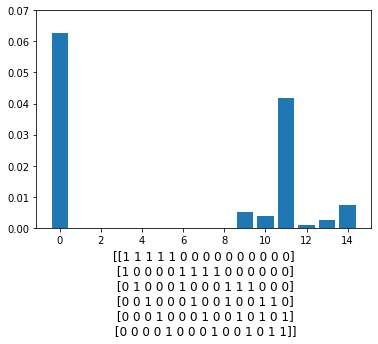

In [56]:
plt.bar(range(len(ln2t)),Pn2t)
plt.xlabel(np.transpose(np.array(ln2t)), fontsize=12);
plt.ylim((0,0.07))

## Patterns of 4 photons

In [57]:
ln =patterns(4,nmodes)
print(len(ln))
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

15
Sample 0 of 15 (1, 1, 1, 1, 0, 0)
0.0025062445
Sample 1 of 15 (1, 1, 1, 0, 1, 0)
0.0018321315
Sample 2 of 15 (1, 1, 1, 0, 0, 1)
0.020823289
Sample 3 of 15 (1, 1, 0, 1, 1, 0)
0.00037856627
Sample 4 of 15 (1, 1, 0, 1, 0, 1)
0.0012307017
Sample 5 of 15 (1, 1, 0, 0, 1, 1)
0.0036809358
Sample 6 of 15 (1, 0, 1, 1, 1, 0)
1.0474253e-08
Sample 7 of 15 (1, 0, 1, 1, 0, 1)
3.092333e-08
Sample 8 of 15 (1, 0, 1, 0, 1, 1)
-5.5946194e-09
Sample 9 of 15 (1, 0, 0, 1, 1, 1)
4.347878e-09
Sample 10 of 15 (0, 1, 1, 1, 1, 0)
-1.3216974e-08
Sample 11 of 15 (0, 1, 1, 1, 0, 1)
1.8275674e-09
Sample 12 of 15 (0, 1, 1, 0, 1, 1)
-1.679361e-08
Sample 13 of 15 (0, 1, 0, 1, 1, 1)
-1.6060536e-09
Sample 14 of 15 (0, 0, 1, 1, 1, 1)
0.00068254047
Done


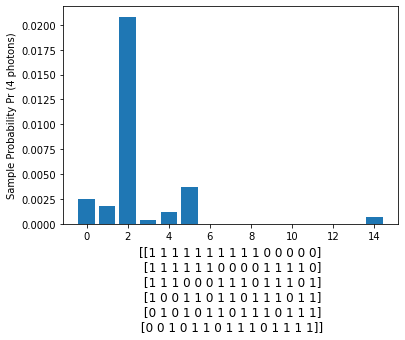

In [58]:
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.bar(range(npatterns),Pn)
plt.ylabel('Sample Probability Pr (4 photons)');

# Check the weights of layers

In [59]:
model.layers

In [60]:
for j in range(3,len(model.layers)-1):
    print('squeezer layer '+repr(j)+ ' r= '+repr(model.layers[j].r.numpy()) \
    + ' theta='+repr(model.layers[j].theta.numpy()))

squeezer layer 3 r= 0.88 theta=0.7853982
squeezer layer 4 r= 0.88 theta=0.7853982
squeezer layer 5 r= 0.88 theta=0.7853982
squeezer layer 6 r= 0.88 theta=0.7853982
squeezer layer 7 r= 0.88 theta=0.7853982
squeezer layer 8 r= 0.88 theta=0.7853982


In [61]:
tf.print(model.layers[9].d)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [62]:
tf.print(model.layers[2].get_M())

([[0.376002789 -0.22700797 -0.350534409 ... -0.086766988 0.220724642 0.238700196]
 [0.22700797 0.376002789 -0.0794462264 ... 0.0560056418 -0.238700196 0.220724642]
 [0.0958849564 -0.234319389 -0.113003924 ... 0.0462155491 -0.135839403 -0.537319839]
 ...
 [0.0707309693 0.318539 0.183523238 ... 0.576828718 -0.309097767 0.00752966106]
 [0.341231257 -0.225671187 0.572178185 ... -0.110756904 0.407212883 0.0962017477]
 [0.225671187 0.341231257 -0.182876647 ... -0.368596315 -0.0962017477 0.407212883]], [[0.376002789 0.22700797 0.0958849564 ... 0.0707309693 0.341231257 0.225671187]
 [-0.22700797 0.376002789 -0.234319389 ... 0.318539 -0.225671187 0.341231257]
 [-0.350534409 -0.0794462264 -0.113003924 ... 0.183523238 0.572178185 -0.182876647]
 ...
 [-0.086766988 0.0560056418 0.0462155491 ... 0.576828718 -0.110756904 -0.368596315]
 [0.220724642 -0.238700196 -0.135839403 ... -0.309097767 0.407212883 -0.0962017477]
 [0.238700196 0.220724642 -0.537319839 ... 0.00752966106 0.0962017477 0.407212883]])

# Compute the statistical probability of pairs

In [63]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.12573029100894928 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.06274283677339554 pattern (1, 1, 0, 0, 0, 0)
Photons 2 Sample 2 of 15 Pr=4.3016996187361656e-08 pattern (1, 0, 1, 0, 0, 0)
Photons 2 Sample 3 of 15 Pr=5.121165713717346e-08 pattern (1, 0, 0, 1, 0, 0)
Photons 2 Sample 4 of 15 Pr=6.730545010213973e-09 pattern (1, 0, 0, 0, 1, 0)
Photons 2 Sample 5 of 15 Pr=1.4367969924933277e-08 pattern (1, 0, 0, 0, 0, 1)
Photons 2 Sample 6 of 15 Pr=4.532989805738907e-08 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 7 of 15 Pr=4.842695489060134e-08 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 8 of 15 Pr=1.4409806681214832e-09 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=2.0157585822744295e-08 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 10 of 15 Pr=0.005022257566452026 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.003671390935778618 pattern (0, 0, 1, 

In [64]:
probn

array([0.12573029, 0.12376554, 0.03113442])

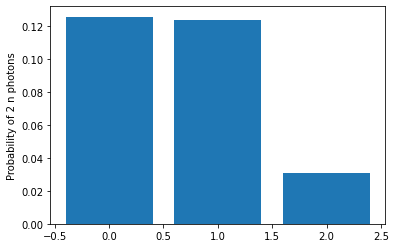

In [65]:
plt.bar(range(nmax+1),probn)
#plt.xlabel(ln, fontsize=6);
plt.ylabel('Probability of 2 n photons');

Looks that the overall probability does not change, but most of the couples appears in the target modes